<b>Histopathologic Cancer Detection</b> <br><br>
The aim of this binary classification task is to identify metastases in images of histopathologic tissue using a convolutional neural network (CNN). We're provided with around 220 000 96 x 96 pixel images of pathology scans, courtesy of Bas Veeling, Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak. <br>
The data can be found at https://www.kaggle.com/c/histopathologic-cancer-detection


In [9]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [06:32<00:00, 21.9MB/s]
100% 6.31G/6.31G [06:32<00:00, 17.3MB/s]


In [10]:
!mkdir cancer
!mv histopathologic-cancer-detection.zip cancer

In [11]:
!unzip cancer/histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

<b> Exploratory Data Analysis </b><br><br>
As mentioned above, the dataset contains around 220k images, around 130k of them being benign (no cancer) and the remaining ~89k ale malignant (tumorous). Malignant images contain at least one pixel of tumor tissue in the center region of the image (32 x 32 pixels). The .csv file associated with the project has two columns, the id of an image corresponding to a .tif file and the label (0 for bening and 1 for malignant). Since there aren't many features to talk about, I've included some images with their respective labels instead.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

In [13]:
df = pd.read_csv('train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [14]:
# get the number of images and the ratio of positive to negative
print(len(df))
print(df['label'].value_counts())

220025
label
0    130908
1     89117
Name: count, dtype: int64


In [15]:
# get the shape of images
img = plt.imread("train/"+dlayerf.iloc[0]['id']+'.tif')
print('Shape of images:', img.shape)

Shape of images: (96, 96, 3)


Label: 0


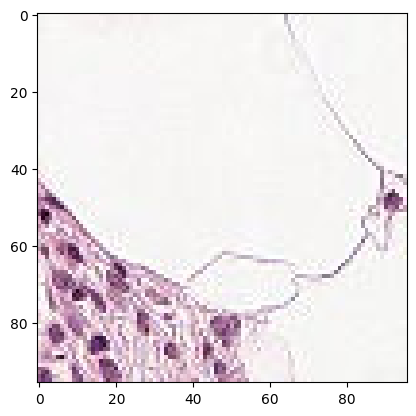

Label: 1


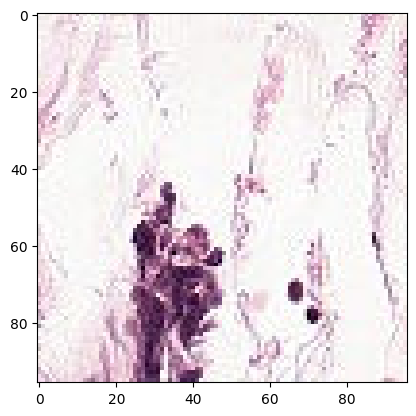

Label: 0


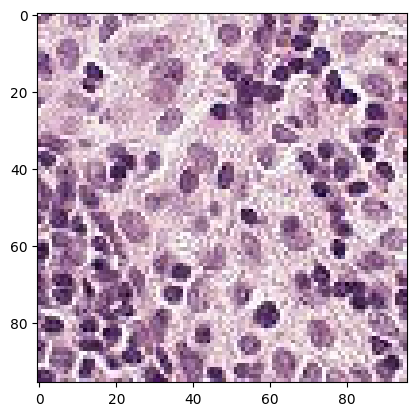

Label: 0


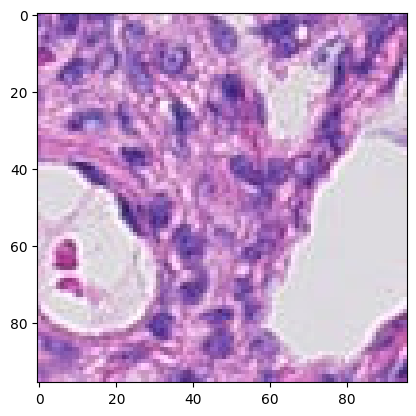

Label: 0


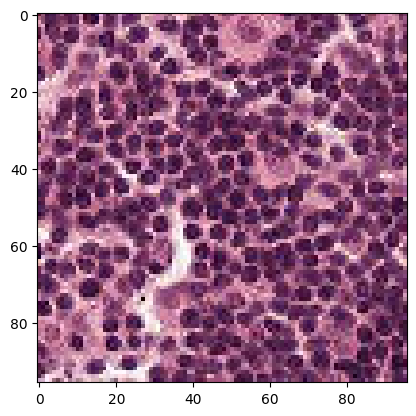

Label: 0


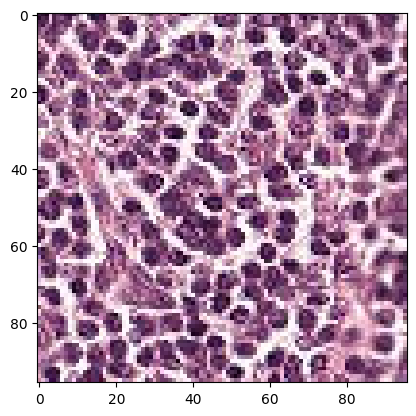

Label: 1


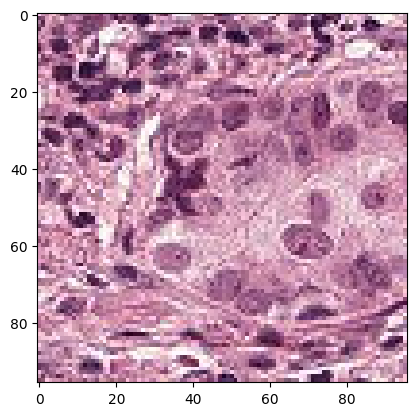

Label: 1


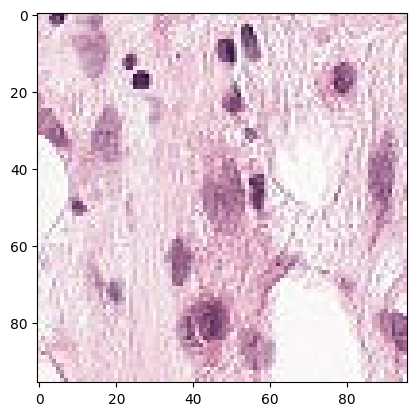

Label: 0


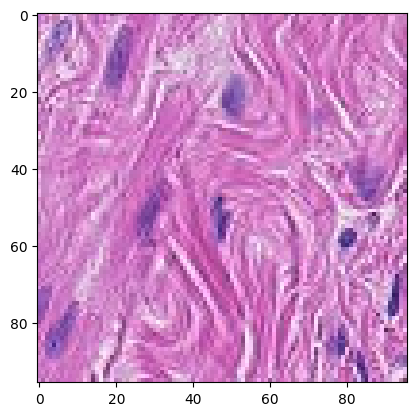

Label: 0


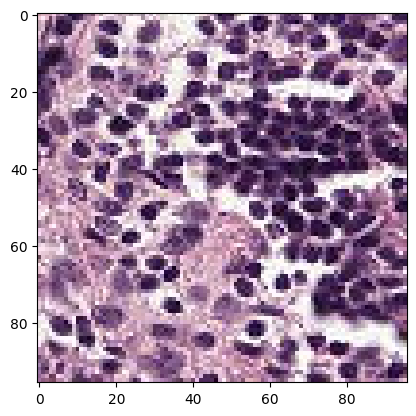

In [16]:
for i in range(10):
    img = plt.imread("train/"+df.iloc[i]['id']+'.tif')
    # print the corresponding label of the image
    print('Label:', df.iloc[i]['label'])
    plt.imshow(img)
    plt.show()

<b>Model Architecture </b><br><br>
Frist up, ImageDataGenerator is used to rescale the images (pixels are rescaled from 0-255 to 0-1) and split into a training and validation set. Both generators (train_generator and validation_generator) normalize the images, resize them to 96x96 pixels, and generate batches of 64 images at a time. As for the parameters, x_col specifies the file name, y_col specifies the output label(0 or 1) target_size resizes the images to 96 x 96. <br><br>
The model uses a series of convolutional layers with increasing filter sizes (16 -> 32 -> 64 -> 128) to capture more complex features at different spatial scales. MaxPooling is applied after each convolutional block to reduce the spatial dimensions and so are Dropout layers to reduce overfitting. The Dense layers process the flattened feature map, with a final sigmoid activation for binary classification. Binary cross entropy is used as the loss function with Adam being the optimizer. In terms of training epochs, ~15 turned to be the sweet spot, with higher values introducing overfitting and lower values not converging. <br><br>
Now let's look at the model and break it down layer by layer:<br>
First Convolutional Block:<br>
        Input Layer: Takes images of size 96×9696×96 with 3 color channels (RGB).<br>
        Conv2D Layer (16 filters): A 2D convolutional layer with 16 filters and a kernel size of 3x3, using the ReLU activation function. The padding='same' ensures the output size is the same as the input size. This layer is followed by two identical convolutional layers.<br>
        Dropout Layer (0.3): A dropout layer that randomly sets 30% of the neurons to zero to prevent overfitting.<br>
        MaxPooling2D Layer: Reduces the spatial dimensions by a factor of 3x3, helping to downsample and reduce computational cost.<br><br>
Second and Third Convolutional Block:<br>
        Conv2D Layer (32 and 64 filters respectively): A 2D convolutional layer with 32/64 filters (increased from 16) and the same parameters as before. This layer is followed by two identical convolutional layers.
        <br><br>
Fourth Convolutional Block:<br>
        Conv2D Layer (128 filters): A 2D convolutional layer with 128 filters (increased further) using the ELU (Exponential Linear Unit) activation function instead of ReLU. ELU often helps with learning deep networks by avoiding vanishing gradients. This layer is followed by two identical convolutional layers.<br>
        <br>
Flatten Layer:<br>
        Flattens the output from the convolutional layers into a 1D vector in preparation for fully connected layers (dense layers).<br><br>
Dense (Fully Connected) Layers:<br>
        Dense Layer (128 units): A fully connected layer with 128 units and ReLU activation. This helps to learn more complex relationships in the data.<br>
        Dropout Layer (0.3): Another dropout layer to prevent overfitting.<br>
        Output Layer (1 unit): A dense layer with 1 unit and sigmoid activation. This suggests the model is set up for binary classification (e.g., distinguishing between two classes).<br><br>


    

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
)

test_datagen = ImageDataGenerator(rescale=1./255)
df['id']=df['id'].apply(lambda x: x+'.tif')
df['label'] = df['label'].astype(str)
train_path = 'train'
valid_path = 'train'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
                has_ext=False,
                subset='training',
                target_size=(96, 96),
                batch_size=64,
                class_mode='binary'
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
                has_ext=False,
                subset='validation',
                target_size=(96, 96),
                batch_size=64,
                shuffle=False,
                class_mode='binary'
                )


Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [ ]:
def build_model():
  # 1st convolutional block
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size = 3))
  # 2nd convolutional block
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size = 3))
  # 3rd convolutional block
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size = 3))
  # 4th convolutional block
  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
  model.add(Dropout(0.3))
  # flatten, dense and output layers
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation = 'sigmoid'))

  return model


In [ ]:
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 96, 96, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 96, 96, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 96, 96, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 96, 96, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 637,313 (2.43 MB)

 Trainable params: 637,313 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

step_train = train_generator.n//train_generator.batch_size
step_valid = validation_generator.n//validation_generator.batch_size

model.fit(train_generator, steps_per_epoch=step_train, epochs=15,
          validation_data=validation_generator, validation_steps=step_valid)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 425s 159ms/step - accuracy: 0.7639 - loss: 0.4963 - val_accuracy: 0.8346 - val_loss: 0.4131
Epoch 2/15
   1/2578 ━━━━━━━━━━━━━━━━━━━━ 2:05 49ms/step - accuracy: 0.7969 - loss: 0.4057

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.7969 - loss: 0.4057 - val_accuracy: 0.9333 - val_loss: 0.3445
Epoch 3/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 307s 119ms/step - accuracy: 0.8509 - loss: 0.3470 - val_accuracy: 0.8670 - val_loss: 0.3286
Epoch 4/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.7969 - loss: 0.3848 - val_accuracy: 0.9333 - val_loss: 0.1818
Epoch 5/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 309s 114ms/step - accuracy: 0.8731 - loss: 0.3033 - val_accuracy: 0.8626 - val_loss: 0.3256
Epoch 6/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8906 - loss: 0.2928 - val_accuracy: 0.9667 - val_loss: 0.2591
Epoch 7/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 293s 114ms/step - accuracy: 0.8868 - loss: 0.2770 - val_accuracy: 0.8571 - val_loss: 0.3248
Epoch 8/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.8750 - loss: 0.3331 - val_accuracy: 0.9333 - val_loss: 0.2641
Epoch 9/15
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 300s 116ms/step - accuracy: 0.8969 - loss:

<b>Results, Analysis and Conclusion </b><br><br>
Using sklearn's classification report, the model achieved decent results across the board. Recall for malignant images was the lowest at 83% percent, meaning that it’s relatively good at correctly predicting malignant cases when it does predict them (high precision), but it misses about 17% of the actual malignant cases. The upside to this is that the model would also likely prevent unnecessary treatment or further expensive diagnosis as it rarely misses when detecting benign cases.

Potential room for improvement: <br>
Adjusting the decision threshold to favor class 1 (malignant).
Using techniques like oversampling, undersampling, or SMOTE to balance the dataset if it’s imbalanced.
Focusing on class-specific penalties in the loss function to emphasize the importance of malignant cases.
However, we need to keep in mind the precision-recall trade-off, meaning that increasing recall might reduce precision and vice versa.

In [ ]:
# get predictions on the validation data
y_pred = model.predict(validation_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# get true labels
y_true = validation_generator.classes

# calculate and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)


860/860 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     32758
           1       0.94      0.83      0.88     22248

    accuracy                           0.91     55006
   macro avg       0.91      0.90      0.90     55006
weighted avg       0.91      0.91      0.91     55006



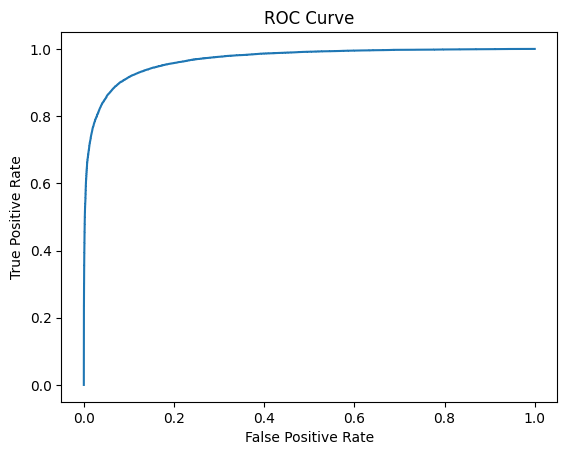

In [ ]:
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# get the roc score
roc_score = roc_auc_score(y_true, y_pred)
print('ROC Score:', roc_score)

ROC Score: 0.9686727730498962


In [ ]:
# print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[31487  1271]
 [ 3728 18520]]
